In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import os
import h5py
import pickle
import numpy.linalg as la
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.kernel_approximation import RBFSampler

# Load embeddings and align classes

In [2]:
embeddings = h5py.File('embeddings.h5', 'r')

def printname(name):
    print(name)
embeddings.visit(printname)

irmas
irmas/openl3
irmas/openl3/features
irmas/openl3/keys
irmas/vggish
irmas/vggish/features
irmas/vggish/keys
irmas/yamnet
irmas/yamnet/features
irmas/yamnet/keys
openmic
openmic/openl3
openmic/openl3/features
openmic/openl3/keys
openmic/vggish
openmic/vggish/features
openmic/vggish/keys
openmic/yamnet
openmic/yamnet/features
openmic/yamnet/keys


In [3]:
with open('class-map-10.json', 'r') as f: # only consider 10 classes of Openmic dataset
    class_map = json.load(f)
    
class_map

{'cello': 3,
 'clarinet': 4,
 'flute': 7,
 'guitar': 8,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'trumpet': 16,
 'violin': 18,
 'voice': 19}

In [4]:
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

In [5]:
# use a Pandas DataFrame to record all results and save into a csv file later
result_all = pd.DataFrame({'instrument': [],
                          'train_set': [],
                          'test_set': [],
                          'precision': [],
                          'recall': [],
                          'f1-score': [],
                          'support': [],
                          'accuracy': [],
                          'roc_auc': [],
                          'ap': []
                         })

In [6]:
embedding_name = 'yamnet'

# irmas->irmas

In [7]:
# irmas: Vggish embedding
feature = np.array(embeddings['irmas'][embedding_name]['features'])
keys_ori = np.array(embeddings['irmas'][embedding_name]['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

(33525, 1024) (33525,)
(6705,)


In [8]:
key_clip

array(['001__[gel][dru][pop_roc]0829__1',
       '001__[gel][dru][pop_roc]0829__2',
       '001__[gel][dru][pop_roc]0829__3', ..., '[voi][pop_roc]2548__1',
       '[voi][pop_roc]2548__2', '[voi][pop_roc]2548__3'], dtype=object)

In [9]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 1024) (6705,)


In [10]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

In [11]:
# these loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(str(key_clip[k])))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [12]:
#keys = np.array([str(k, encoding='utf-8') for k in key_clip])
keys = np.array(key_clip)
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [13]:
# use the split indices to partition the features, labels, and masks
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

# print out the sliced shapes as a sanity check
print(X_train.shape)
print(X_test.shape)

(5039, 1024)
(1666, 1024)


In [14]:
############################# project the LDA direction #############################
file = open('kernelize_LDA_' + embedding_name + '_coef_genre.pickle', 'rb')
globals()['LDA_coef_' + embedding_name] = pickle.load(file)
file.close()

W = globals()['LDA_coef_' + embedding_name]
U, s, V = la.svd(W, full_matrices=False)
A = np.dot(V.T, V)
print(W.shape, U.shape, s.shape, V.shape, A.shape)

(5, 1024) (5, 5) (5,) (5, 1024) (1024, 1024)


In [15]:
train_set_name, test_set_name = 'irmas', 'irmas'

# use a dictionary to include the classifier for each instrument trained on the dataset based on the embedding
globals()['models_'+train_set_name] = dict()  

X_train_inst = X_train
X_test_inst = X_test

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_train_inst = Y_true_train==instrument
    Y_true_test_inst = Y_true_test==instrument
    
    ######## kernelize embedding ############
    feature_map_fourier = RBFSampler(gamma=1, n_components=X_train_inst.shape[1], random_state=0)
    X_train_inst = feature_map_fourier.fit_transform(X_train_inst, Y_true_train_inst)
    X_test_inst = feature_map_fourier.transform(X_test_inst)
    
    X_train_inst = X_train_inst.dot(np.eye(len(A)) - A)
    X_test_inst = X_test_inst.dot(np.eye(len(A)) - A)
    
    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=0, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }  
    scoring = 'f1'; cv = 3
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)  
    
    # fit the model
    clf.fit(X_train, Y_true_train_inst)
    
    # predict
    Y_pred_test_inst = clf.predict(X_test_inst)
    
    # Get prediction scores for the positive class
    Y_pred_test_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # store the classifier in the model dictionary
    globals()['models_'+train_set_name][instrument] = clf
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.94      0.85      0.89      1572
        True       0.04      0.10      0.05        94

    accuracy                           0.80      1666
   macro avg       0.49      0.47      0.47      1666
weighted avg       0.89      0.80      0.84      1666

ROC-AUC = 0.459		AP = 0.050
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.92      0.85      0.88      1539
        True       0.06      0.11      0.07       127

    accuracy                           0.79      1666
   macro avg       0.49      0.48      0.48      1666
weighted avg       0.85      0.79      0.82      1666

ROC-AUC = 0.433		AP = 0.067
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.93      0.93    

# openmic->openmic

In [16]:
# openmic: vggish embedding
feature = np.array(embeddings['openmic'][embedding_name]['features'])
keys = np.array(embeddings['openmic'][embedding_name]['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)
key_clip.shape

(380000, 1024) (380000,)


(20000,)

In [17]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

#key_clip = np.array([str(k, 'utf-8') for k in key_clip])
key_clip = np.array(key_clip)
key_clip

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 1024) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype=object)

In [18]:
# key-label map using the information from the dataset source
data_root = '/import/c4dm-datasets/openmic-2018/openmic-2018/'
# Replaced the above by a local symbolic link within the github repo
# data_root = 'openmic-2018/'

np_load_old = np.load   # save np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True,**k)   # modify the default parameters of np.load

Ytrue = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_true']
Ymask = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_mask']
sample_key = np.load(os.path.join(data_root, 'openmic-2018.npz'))['sample_key']

np.load = np_load_old   # restore np.load for future normal usage
del(np_load_old)

print(Ytrue.shape, Ymask.shape, sample_key.shape)

(20000, 20) (20000, 20) (20000,)


In [19]:
Y_true = []
Y_mask = []

for key in tqdm(key_clip):
    Y_true.append(Ytrue[sample_key==key])
    Y_mask.append(Ymask[sample_key==key])
    
Y_true = np.squeeze(np.array(Y_true))
Y_mask = np.squeeze(np.array(Y_mask))

X = feature_clip
del(feature_clip)

print(X.shape, Y_true.shape, Y_mask.shape)

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 1024) (20000, 20) (20000, 20)


In [20]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [21]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [22]:
X_train = X[idx_train]
X_test = X[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

print(X_train.shape); print(X_test.shape)

(14915, 1024)
(5085, 1024)


In [23]:
X_train = X_train.dot(np.eye(len(A)) - A)
X_test = X_test.dot(np.eye(len(A)) - A)

print(X_train.shape, X_test.shape)

(14915, 1024) (5085, 1024)


In [24]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'openmic', 'openmic'

# use a dictionary to include the classifier for each instrument trained on the dataset based on the embedding
globals()['models_'+train_set_name] = dict()  

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst = X_train[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5
    
    ######## kernelize embedding ############
    feature_map_fourier = RBFSampler(gamma=1, n_components=X_train_inst.shape[1], random_state=0)
    X_train_inst = feature_map_fourier.fit_transform(X_train_inst, Y_true_train_inst)
    X_test_inst = feature_map_fourier.transform(X_test_inst)
    
    X_train_inst = X_train_inst.dot(np.eye(len(A)) - A)
    X_test_inst = X_test_inst.dot(np.eye(len(A)) - A)

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=0, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }  
    scoring = 'f1'; cv = 3
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_true_train_inst)

    # predict
    Y_pred_test_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_test_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # store the classifier in the model dictionary
    globals()['models_'+train_set_name][instrument] = clf
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.57      0.56      0.56       259
        True       0.50      0.52      0.51       226

    accuracy                           0.54       485
   macro avg       0.54      0.54      0.54       485
weighted avg       0.54      0.54      0.54       485

ROC-AUC = 0.543		AP = 0.506
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.79      0.59      0.68       503
        True       0.22      0.42      0.29       137

    accuracy                           0.55       640
   macro avg       0.50      0.51      0.48       640
weighted avg       0.67      0.55      0.59       640

ROC-AUC = 0.500		AP = 0.208
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.68      0.55    

# irmas->openmic

In [25]:
train_set_name, test_set_name = 'irmas', 'openmic' 

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations 
    # This is what the mask arrays are for
    test_inst = Y_mask_test[:, inst_num]

    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5
    
    ######## kernelize embedding ############
    feature_map_fourier = RBFSampler(gamma=1, n_components=X_train_inst.shape[1], random_state=0)
    X_train_inst = feature_map_fourier.fit_transform(X_train_inst, Y_true_train_inst)
    X_test_inst = feature_map_fourier.transform(X_test_inst)
    
    X_train_inst = X_train_inst.dot(np.eye(len(A)) - A)
    X_test_inst = X_test_inst.dot(np.eye(len(A)) - A)

    # evaluate the classifier 
    Y_pred_test_inst =  globals()['models_'+train_set_name][instrument].predict(X_test_inst)
    Y_pred_test_scores =  globals()['models_'+train_set_name][instrument].predict_proba(X_test_inst)[:, 1]

    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.53      0.84      0.65       259
        True       0.43      0.14      0.21       226

    accuracy                           0.51       485
   macro avg       0.48      0.49      0.43       485
weighted avg       0.48      0.51      0.44       485

ROC-AUC = 0.506		AP = 0.466
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.80      0.91      0.85       503
        True       0.30      0.14      0.19       137

    accuracy                           0.75       640
   macro avg       0.55      0.53      0.52       640
weighted avg       0.69      0.75      0.71       640

ROC-AUC = 0.525		AP = 0.236
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.69      0.79    

# openmic->irmas

In [26]:
# irmas: vggish embedding
feature = np.array(embeddings['irmas'][embedding_name]['features'])
keys_ori = np.array(embeddings['irmas'][embedding_name]['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(33525, 1024) (33525,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 1024) (6705,)


In [27]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [28]:
#keys = np.array([str(k, 'utf-8') for k in key_clip])
keys = np.array(key_clip)
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [29]:
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

print(X_train.shape)
print(X_test.shape)

(5039, 1024)
(1666, 1024)


In [30]:
X_train = X_train.dot(np.eye(len(A)) - A)
X_test = X_test.dot(np.eye(len(A)) - A)

print(X_train.shape, X_test.shape)

(5039, 1024) (1666, 1024)


In [31]:
train_set_name, test_set_name = 'openmic', 'irmas' 

X_train_inst = X_train
X_test_inst = X_test

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_test_inst = Y_true_test==instrument
    
    ######## kernelize embedding ############
    feature_map_fourier = RBFSampler(gamma=1, n_components=X_train_inst.shape[1], random_state=0)
    X_train_inst = feature_map_fourier.fit_transform(X_train_inst, Y_true_train_inst)
    X_test_inst = feature_map_fourier.transform(X_test_inst)
    
    X_train_inst = X_train_inst.dot(np.eye(len(A)) - A)
    X_test_inst = X_test_inst.dot(np.eye(len(A)) - A)

    # evaluate the classifier
    Y_pred_test_inst =  globals()['models_'+train_set_name][instrument].predict(X_test_inst)
    Y_pred_test_scores =  globals()['models_'+train_set_name][instrument].predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.95      0.53      0.68      1572
        True       0.06      0.49      0.11        94

    accuracy                           0.53      1666
   macro avg       0.50      0.51      0.39      1666
weighted avg       0.90      0.53      0.65      1666

ROC-AUC = 0.528		AP = 0.066
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.91      0.47      0.62      1539
        True       0.07      0.46      0.12       127

    accuracy                           0.47      1666
   macro avg       0.49      0.47      0.37      1666
weighted avg       0.85      0.47      0.58      1666

ROC-AUC = 0.441		AP = 0.067
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.93      0.46    

# Plot result on each instrument

In [32]:
# save all result into a csv file
result_all.to_csv('YAMnet_crossdataset_result_kernelLDA_genre.csv', index=False)

In [33]:
# check the PRF averaged over all instruments for each case:

train_irmas = result_all[result_all['train_set']=='irmas']
train_openmic = result_all[result_all['train_set']=='openmic']

irmas_irmas = train_irmas[train_irmas['test_set']=='irmas']
irmas_openmic = train_irmas[train_irmas['test_set']=='openmic']
openmic_openmic = train_openmic[train_openmic['test_set']=='openmic']
openmic_irmas = train_openmic[train_openmic['test_set']=='irmas']

print('PRF and accuracy of Vggish averaged over all instruments for each case:')
print('openmic->openmic:{}'.format(list(openmic_openmic[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))
print('irmas->openmic:{}'.format(list(irmas_openmic[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))
print('irmas->irmas:{}'.format(list(irmas_irmas[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))
print('openmic->irmas:{}'.format(list(openmic_irmas[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))

PRF and accuracy of Vggish averaged over all instruments for each case:
openmic->openmic:[0.48, 0.53, 0.5, 0.53, 0.5, 0.48]
irmas->openmic:[0.48, 0.36, 0.35, 0.54, 0.51, 0.49]
irmas->irmas:[0.1, 0.31, 0.12, 0.64, 0.5, 0.1]
openmic->irmas:[0.1, 0.58, 0.17, 0.43, 0.5, 0.1]


In [2]:
# save the result of VGGish, yamnet, and OpenL3 into one csv file

vggish = pd.read_csv('VGGish_crossdataset_result_kernelize.csv')
openl3 = pd.read_csv('OpenL3_crossdataset_result_kernelize.csv')
yamnet = pd.read_csv('YAMnet_crossdataset_result_kernelize.csv')

# add embedding information, concatenate result
vggish['embedding'] = ['vggish'] * len(vggish['instrument'])
openl3['embedding'] = ['openl3'] * len(openl3['instrument'])
yamnet['embedding'] = ['yamnet'] * len(openl3['instrument'])

result_all_conca = pd.concat([vggish, openl3, yamnet], ignore_index=True)

# move embedding to the first column
cols = ['embedding', 'instrument', 'train_set', 'test_set', 'precision', 'recall', 'f1-score', 'support', 'accuracy', 'roc_auc', 'ap']
result_all_conca =result_all_conca[cols]

result_all_conca.to_csv('crossdataset_generalization_result_kernelize.csv', index=False)

In [3]:
# save the result of VGGish, yamnet, and OpenL3 into one csv file

vggish = pd.read_csv('VGGish_crossdataset_result_kernelLDA.csv')
openl3 = pd.read_csv('OpenL3_crossdataset_result_kernelLDA.csv')
yamnet = pd.read_csv('YAMnet_crossdataset_result_kernelLDA.csv')

# add embedding information, concatenate result
vggish['embedding'] = ['vggish'] * len(vggish['instrument'])
openl3['embedding'] = ['openl3'] * len(openl3['instrument'])
yamnet['embedding'] = ['yamnet'] * len(openl3['instrument'])

result_all_conca = pd.concat([vggish, openl3, yamnet], ignore_index=True)

# move embedding to the first column
cols = ['embedding', 'instrument', 'train_set', 'test_set', 'precision', 'recall', 'f1-score', 'support', 'accuracy', 'roc_auc', 'ap']
result_all_conca =result_all_conca[cols]

result_all_conca.to_csv('crossdataset_generalization_result_kernelLDA.csv', index=False)

In [4]:
# save the result of VGGish, yamnet, and OpenL3 into one csv file

vggish = pd.read_csv('VGGish_crossdataset_result_kernelLDA_genre.csv')
openl3 = pd.read_csv('OpenL3_crossdataset_result_kernelLDA_genre.csv')
yamnet = pd.read_csv('YAMnet_crossdataset_result_kernelLDA_genre.csv')

# add embedding information, concatenate result
vggish['embedding'] = ['vggish'] * len(vggish['instrument'])
openl3['embedding'] = ['openl3'] * len(openl3['instrument'])
yamnet['embedding'] = ['yamnet'] * len(openl3['instrument'])

result_all_conca = pd.concat([vggish, openl3, yamnet], ignore_index=True)

# move embedding to the first column
cols = ['embedding', 'instrument', 'train_set', 'test_set', 'precision', 'recall', 'f1-score', 'support', 'accuracy', 'roc_auc', 'ap']
result_all_conca =result_all_conca[cols]

result_all_conca.to_csv('crossdataset_generalization_result_kernelLDA_genre.csv', index=False)

In [5]:
df1 = pd.read_csv('crossdataset_generalization_result_kernelize.csv')
df2 = pd.read_csv('crossdataset_generalization_result_kernelLDA.csv')
df3 = pd.read_csv('crossdataset_generalization_result_kernelLDA_genre.csv')
df2['embedding'] = ['vggish-lda'] * 40 + ['openl3-lda'] * 40 + ['yamnet-lda'] * 40 
df3['embedding'] = ['vggish-lda-genre'] * 40 + ['openl3-lda-genre'] * 40 + ['yamnet-lda-genre'] * 40

df = df1.append(df2).append(df3)
df.to_csv('crossdataset_generalization_result_kernelLDA_allcompare.csv')
df

,embedding,instrument,train_set,test_set,precision,recall,f1-score,support,accuracy,roc_auc,ap
0,vggish,cello,irmas,irmas,0.068966,0.468085,0.120219,94.0,0.613445,0.552792,0.067386
1,vggish,clarinet,irmas,irmas,0.080303,0.417323,0.134689,127.0,0.591236,0.518334,0.090597
2,vggish,flute,irmas,irmas,0.072917,0.404959,0.123581,121.0,0.582833,0.506154,0.073721
3,vggish,guitar,irmas,irmas,0.206198,0.500000,0.291983,346.0,0.496399,0.503230,0.220680
4,vggish,organ,irmas,irmas,0.103352,0.425287,0.166292,174.0,0.554622,0.490740,0.105086
...,...,...,...,...,...,...,...,...,...,...,...
115,yamnet-lda-genre,piano,openmic,irmas,0.101313,0.635294,0.174757,170.0,0.387755,0.517069,0.119235
116,yamnet-lda-genre,saxophone,openmic,irmas,0.091977,0.626667,0.160410,150.0,0.409364,0.523813,0.099635
117,yamnet-lda-genre,trumpet,openmic,irmas,0.084927,0.740000,0.152368,150.0,0.258703,0.469081,0.087481
118,yamnet-lda-genre,violin,openmic,irmas,0.065728,0.293706,0.107417,143.0,0.581032,0.449155,0.073001


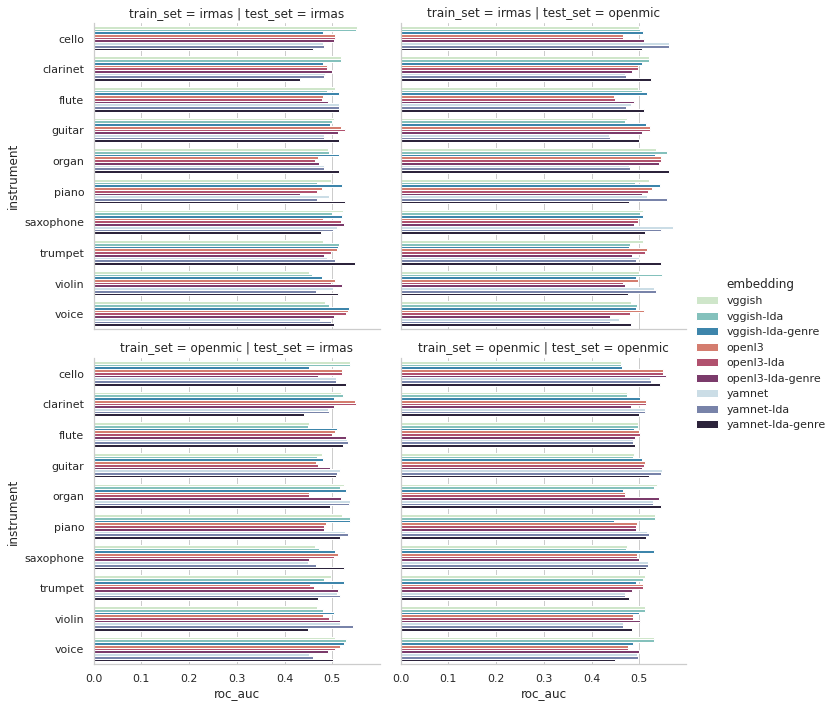

In [6]:
sns.set_theme(context='notebook', style='whitegrid', palette='deep')
diverging_colors = sns.color_palette("GnBu", 3) + sns.color_palette("flare", 3) + \
                   sns.color_palette("ch:s=.25,rot=-.25", 3) 
hue_order=['vggish', 'vggish-lda', 'vggish-lda-genre', 'openl3', 'openl3-lda', 'openl3-lda-genre',
          'yamnet', 'yamnet-lda', 'yamnet-lda-genre']

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            hue_order=hue_order, palette=diverging_colors);

plt.savefig('crossdataset_generalization_auc_kernelLDA_genre.png')

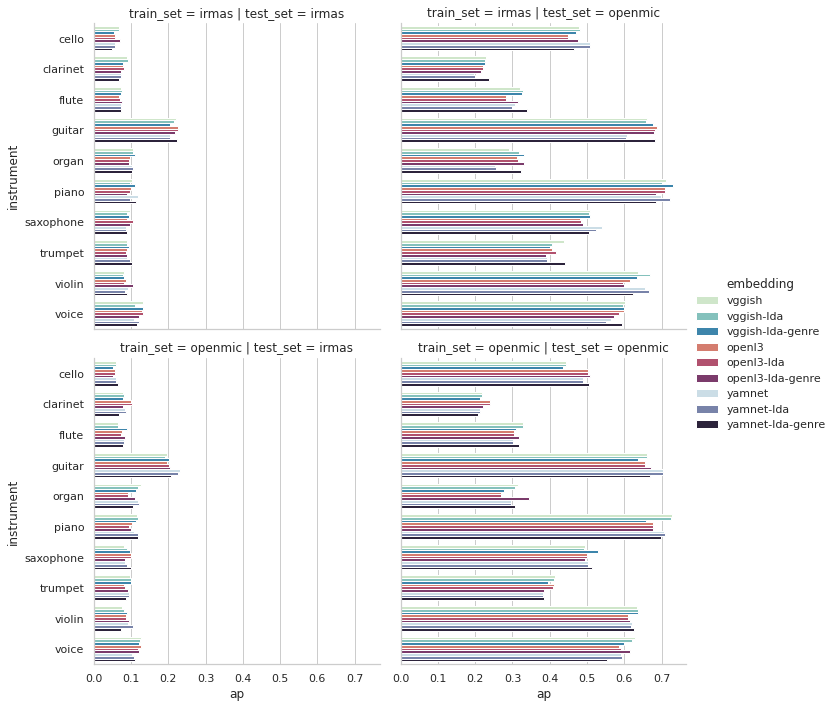

In [7]:
sns.set_theme(context='notebook', style='whitegrid')
diverging_colors = sns.color_palette("GnBu", 3) + sns.color_palette("flare", 3) + \
                   sns.color_palette("ch:s=.25,rot=-.25", 3) 
hue_order=['vggish', 'vggish-lda', 'vggish-lda-genre', 'openl3', 'openl3-lda', 'openl3-lda-genre',
          'yamnet', 'yamnet-lda', 'yamnet-lda-genre']

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='ap', hue='embedding', kind='bar', 
            hue_order=hue_order, palette=diverging_colors);

plt.savefig('crossdataset_generalization_ap_kernelLDA_genre.png')